Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
print(pathlib.Path.cwd())

/mnt/disks/user/project/CNN_assignment_cancer


In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path(r"Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
#class_names_list = ['actinic_keratosis','basal_cell_carcinoma','dermatofibroma','melanoma','nevus','pigmented_benign_keratosis','seborrheic_keratosis','squamous_cell_carcinoma','vascular_lesion']

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels = 'inferred', label_mode = 'int', class_names = None, color_mode = 'rgb', batch_size = batch_size, 
image_size = (img_height, img_width), shuffle = True, seed = 123, validation_split = 0.2, subset = 'training', interpolation = 'bilinear', follow_links = True)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels = 'inferred', label_mode = 'int', class_names = None, color_mode = 'rgb', batch_size = batch_size, 
image_size = (img_height, img_width), shuffle = True, seed = 123, validation_split = 0.2, subset = 'validation', interpolation = 'bilinear', follow_links = True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len (class_names)
print(class_names)
print(num_classes)

['actinic_keratosis', 'basal_cell_carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis', 'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion']
9


In [10]:
print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
#To rescale
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(data_dir_train, target_size=(img_height, img_width), 
                                                     class_mode="categorical", shuffle=True, batch_size=batch_size)

image_batch, label_batch = next(iter(train_data_gen))


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(len(class_names)):
        ax = plt.subplot(5,5,n+1)
        # plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
        plt.imshow(image_batch[n])
        plt.title(class_names[n])
        plt.axis('off')

Found 2239 images belonging to 9 classes.


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

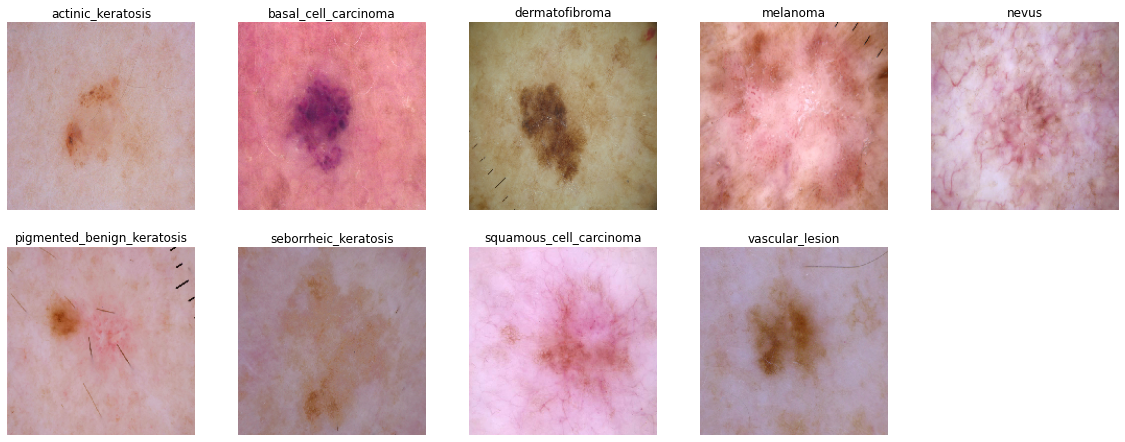

In [12]:
show_batch(image_batch, label_batch)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3))])
model.add(layers.Conv2D(64, (3,3), padding = "same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (3,3), padding = "same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (3,3), padding = "same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
#View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 16)        0

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 174ms/step - loss: 2.0755 - accuracy: 0.1774 - val_loss: 1.8901 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.8754 - accuracy: 0.2915 - val_loss: 1.8468 - val_accuracy: 0.3266
Epoch 3/20
56/56 [==============================] - 2s 35ms/step - loss: 1.7426 - accuracy: 0.3661 - val_loss: 1.6772 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5967 - accuracy: 0.4189 - val_loss: 1.5255 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5143 - accuracy: 0.4782 - val_loss: 1.4963 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4781 - accuracy: 0.4815 - val_loss: 1.4371 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2999 - accuracy: 0.5464 - val_loss: 1.4400 - val_accuracy: 0.5213
Epoch 8/20


### Visualizing training results

In [18]:
#Declare a function to plot the training and validation accuracy and loss
def plot_accuracy_and_loss(history, epochs, legend_location_for_accuracy_plot, legend_location_for_loss_plot):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc = legend_location_for_accuracy_plot)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = legend_location_for_loss_plot)
    plt.title('Training and Validation Loss')
    plt.show()

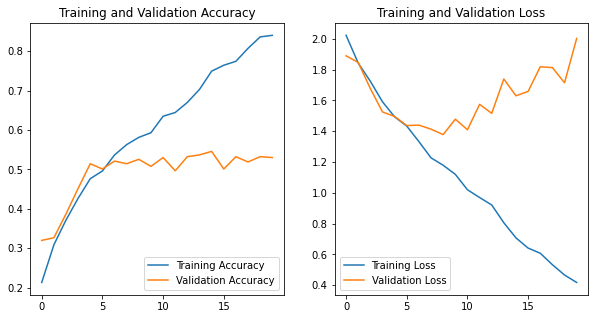

In [19]:
plot_accuracy_and_loss(history, epochs, 'lower right', 'lower left')

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observations**
- There is a huge gap between model train and validation accuracy
- This suggests that perhaps the model learned the traininig data a little too well and when it was time to show the same learnings on the validation set, it doesnt perform as well as it did on the training data.
- This suggestes that this model is **overfitting**.
- We need to use augmentation strategies to augment the data set. We will be adding image rotation,height and width shift, horizontal flip and zoom

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
model_data_augmentation = Sequential()
model_data_augmentation.add(layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)))
# model_data_augmentation.add(layers.experimental.preprocessing.RandomRotation(0.2))
# model_data_augmentation.add(layers.experimental.preprocessing.RandomZoom(0.5))


### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# model_2 = Sequential()
# model_2.add(data_augmentation)
model_data_augmentation.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3)))
model_data_augmentation.add(layers.Conv2D(64, (3,3), padding = "same", activation="relu"))
model_data_augmentation.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_data_augmentation.add(layers.Conv2D(32, (3,3), padding = "same", activation="relu"))
model_data_augmentation.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_data_augmentation.add(layers.Conv2D(16, (3,3), padding = "same", activation="relu"))
model_data_augmentation.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_data_augmentation.add(layers.Flatten())
model_data_augmentation.add(layers.Dense(128, activation="relu"))
model_data_augmentation.add(layers.Dense(num_classes, activation = "softmax"))



### Compiling the model

In [22]:
## Your code goes here
model_data_augmentation.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
history = model_data_augmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 38ms/step - loss: 2.0698 - accuracy: 0.2078 - val_loss: 1.8159 - val_accuracy: 0.3579
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7985 - accuracy: 0.3504 - val_loss: 1.6725 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.6229 - accuracy: 0.4206 - val_loss: 1.4739 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4958 - accuracy: 0.4824 - val_loss: 1.4935 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4641 - accuracy: 0.4894 - val_loss: 1.3848 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3183 - accuracy: 0.5354 - val_loss: 1.3832 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2660 - accuracy: 0.5526 - val_loss: 1.3990 - val_accuracy: 0.5391
Epoch 8/20
56

### Visualizing the results

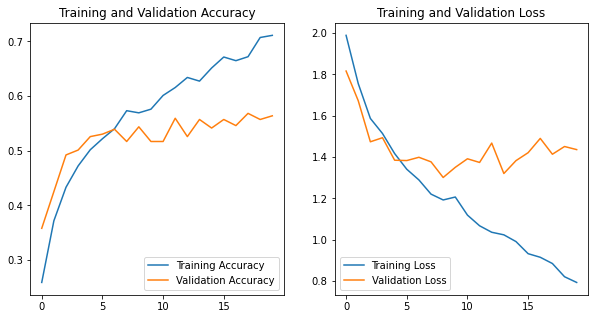

In [24]:
plot_accuracy_and_loss(history, epochs, 'lower right', 'lower left')

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- The difference has been narrowed down but not by much. Seems like we are in the correct direction

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin_cancer_ISIC_The_International_Skin_Imagin...,squamous_cell_carcinoma
1,Skin_cancer_ISIC_The_International_Skin_Imagin...,squamous_cell_carcinoma
2,Skin_cancer_ISIC_The_International_Skin_Imagin...,squamous_cell_carcinoma
3,Skin_cancer_ISIC_The_International_Skin_Imagin...,squamous_cell_carcinoma
4,Skin_cancer_ISIC_The_International_Skin_Imagin...,squamous_cell_carcinoma
...,...,...
2234,Skin_cancer_ISIC_The_International_Skin_Imagin...,dermatofibroma
2235,Skin_cancer_ISIC_The_International_Skin_Imagin...,dermatofibroma
2236,Skin_cancer_ISIC_The_International_Skin_Imagin...,dermatofibroma
2237,Skin_cancer_ISIC_The_International_Skin_Imagin...,dermatofibroma


Class=7, n=181 (8.084%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=6, n=77 (3.439%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=3, n=438 (19.562%)
Class=8, n=139 (6.208%)
Class=2, n=95 (4.243%)


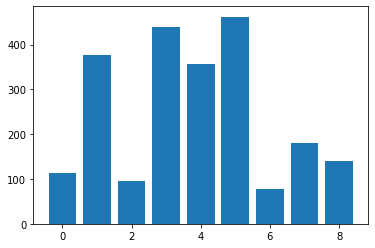

In [26]:
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
##### - Ans:- class 6 i.e. seborrheic_keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
##### - Ans:- Classes 3 and 5 i.e. melanoma and pigmented_benign_keratosis respectively


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install "Augmentor==0.2.8"

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/ubuntu/.local/include/python3.8/UNKNOWN
sysconfig: /home/ubuntu/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
!pip list | grep -i Augmentor

Augmentor                0.2.8
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [30]:
!pip -V

pip 21.1 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)


In [31]:
!python -V

Python 3.8.5


In [33]:
!python -c "import sys; print('\n'.join(sys.path))"


/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload
/home/ubuntu/.local/lib/python3.8/site-packages
/usr/local/lib/python3.8/dist-packages
/usr/lib/python3/dist-packages


In [34]:
import Augmentor #(restart the kernel and start executing cells from the top again, if this import fails. I faced this many times during writing this assignment)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
str(data_dir_train)

'Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train'

In [36]:
path_to_training_dataset = "Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F464C0F6D90>: 100%|██████████| 500/500 [00:07<00:00, 63.01 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F464C174D60>: 100%|██████████| 500/500 [00:07<00:00, 62.98 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F464C105880>: 100%|██████████| 500/500 [00:08<00:00, 61.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1242x1284 at 0x7F464C0B3820>: 100%|██████████| 500/500 [00:40<00:00, 12.46 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F46C817C580>: 100%|██████████| 500/500 [00:42<00:00, 11.87 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented_benign_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F464C17ED60>: 100%|██████████| 500/500 [00:07<00:00, 63.46 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F46A822A370>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F464C145B20>: 100%|██████████| 500/500 [00:07<00:00, 68.84 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular_lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F464C10BBE0>: 100%|██████████| 500/500 [00:07<00:00, 67.42 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output/squamous_cell_carcinoma_original_ISIC_0029315.jpg_f6f6a831-438b-4db8-ad02-44882086fdd2.jpg',
 'Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output/squamous_cell_carcinoma_original_ISIC_0031431.jpg_4c8c3191-ba79-4099-bcb4-a1a7981fdf1b.jpg',
 'Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output/squamous_cell_carcinoma_original_ISIC_0029811.jpg_2636220d-d82d-482f-98a8-93129587f1f1.jpg',
 'Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output/squamous_cell_carcinoma_original_ISIC_0032154.jpg_06c56dde-1a62-4ec1-9cff-9a5244e6b544.jpg',
 'Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous_cell_carcinoma/output/squamous_cell_carcinoma_original_ISIC_0030076.jpg_51f1359b-10ea-4b11-9100-cebf2d9feda5.jpg',
 'Skin_cancer_ISIC_The_Interna

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carcinoma',
 'squamous_cell_carc

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
new_df['Label'].value_counts()

pigmented_benign_keratosis    962
melanoma                      938
basal_cell_carcinoma          876
nevus                         857
squamous_cell_carcinoma       681
vascular_lesion               639
actinic_keratosis             614
dermatofibroma                595
seborrheic_keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
## your code goes here
model_3 = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height,img_width,3))])
model_3.add(layers.Conv2D(64, (3,3), padding = "same", activation="relu"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Conv2D(32, (3,3), padding = "same", activation="relu"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Conv2D(16, (3,3), padding = "same", activation="relu"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(128, activation="relu"))
model_3.add(layers.Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

#### **Todo:**  Train your model

In [50]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 50s 288ms/step - loss: 2.1810 - accuracy: 0.1518 - val_loss: 2.0552 - val_accuracy: 0.2183
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 1.7686 - accuracy: 0.3211 - val_loss: 1.6518 - val_accuracy: 0.4053
Epoch 3/30
169/169 [==============================] - 33s 189ms/step - loss: 1.4076 - accuracy: 0.4673 - val_loss: 1.3032 - val_accuracy: 0.5308
Epoch 4/30
169/169 [==============================] - 34s 198ms/step - loss: 1.1951 - accuracy: 0.5509 - val_loss: 1.2182 - val_accuracy: 0.5353
Epoch 5/30
169/169 [==============================] - 33s 189ms/step - loss: 1.0608 - accuracy: 0.6056 - val_loss: 1.0642 - val_accuracy: 0.6006
Epoch 6/30
169/169 [==============================] - 34s 197ms/step - loss: 0.8751 - accuracy: 0.6792 - val_loss: 1.0290 - val_accuracy: 0.6073
Epoch 7/30
169/169 [==============================] - 33s 189ms/step - loss: 0.7454 - accuracy: 0.7301 - val_loss: 0.8823 - val_ac

#### **Todo:**  Visualize the model results

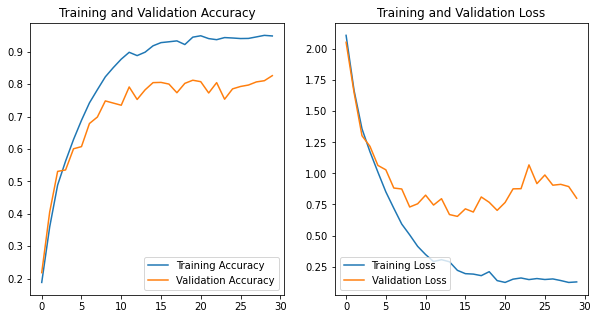

In [51]:
plot_accuracy_and_loss(history, epochs, 'lower right', 'lower left')

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observations**
- The class rebalance helped
- It helped both in increasing training accuracy but also in increasing validation accuracy
- With the training and validation accuracy being this close, the model seems fine enough.